In [2]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [4]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [5]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:48: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:48: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:51: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

In [6]:
values=sector_XS_normalized(amihud)

# Inverse volatility weighting

* Weighting each market by the inverse of its ex-post sample standard deviation.  
* I compute the monthly standard deviation of returns for each futures market and weight each market by the inverse of this number, rescaled to sum to one, to form a global portfolio across all futures markets within the sorted portfolio.  Therefore, each market's dollar contribution to the sorted portfolio is proprtional to the reciprocal of its measured volatility but each market contributes an equal fraction to the total volatlity of the portfolio, ignoring correlations
* Can add that market cap weighting has difficulties in futures space as market cap has no meaning and volatility differs greatly across different asset classes.


In [135]:
def quantile_portfolios_annual_with_rank_vol_weighting(rank_data,price_data,number_of_buckets=10):
    deciles={}
    med_value={}
    vol=pd.DataFrame.rolling(cleansed.resample(rule='m',how='last').pct_change(),36).std().replace(0,1)
    vol=vol.apply(lambda x: np.where(x<0.00289,1,x))
    in_vol=1/(vol.replace(0,1))
    #vol=pd.DataFrame.rolling(price_data.resample(rule='m',how='last').pct_change(),12).std()
    #in_vol=1/(vol.replace(0,1))
    for i in range(0,number_of_buckets,1):
        deciles[str(i)]=pd.Series()
        med_value[str(i)]=pd.Series()
    for y in range(rank_data.dropna(how='all').index[0].year,rank_data.index[-1].year,1):
        year=str(y) + '-12-31'
        for i in range(0,number_of_buckets,1):
            mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
            a=(in_vol[str(y+1)][mkts]).sum(axis=1)
            w=((in_vol[str(y+1)][mkts]).T.div(a)).T
            rtns = w.multiply(price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)]).sum(axis=1)
            med=rank_data[mkts][str(y+1)].median(axis=1)
            deciles[str(i)]=deciles[str(i)].append(rtns)
            med_value[str(i)]=med_value[str(i)].append(med)
    return pd.DataFrame(deciles),pd.DataFrame(med_value)

In [136]:
a,b=quantile_portfolios_annual_with_rank_vol_weighting(values['All'],cleansed,3)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  from ipykernel import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


In [137]:
calc_Sharpe(a)

0    0.248380
1    0.897780
2    0.924804
dtype: float64

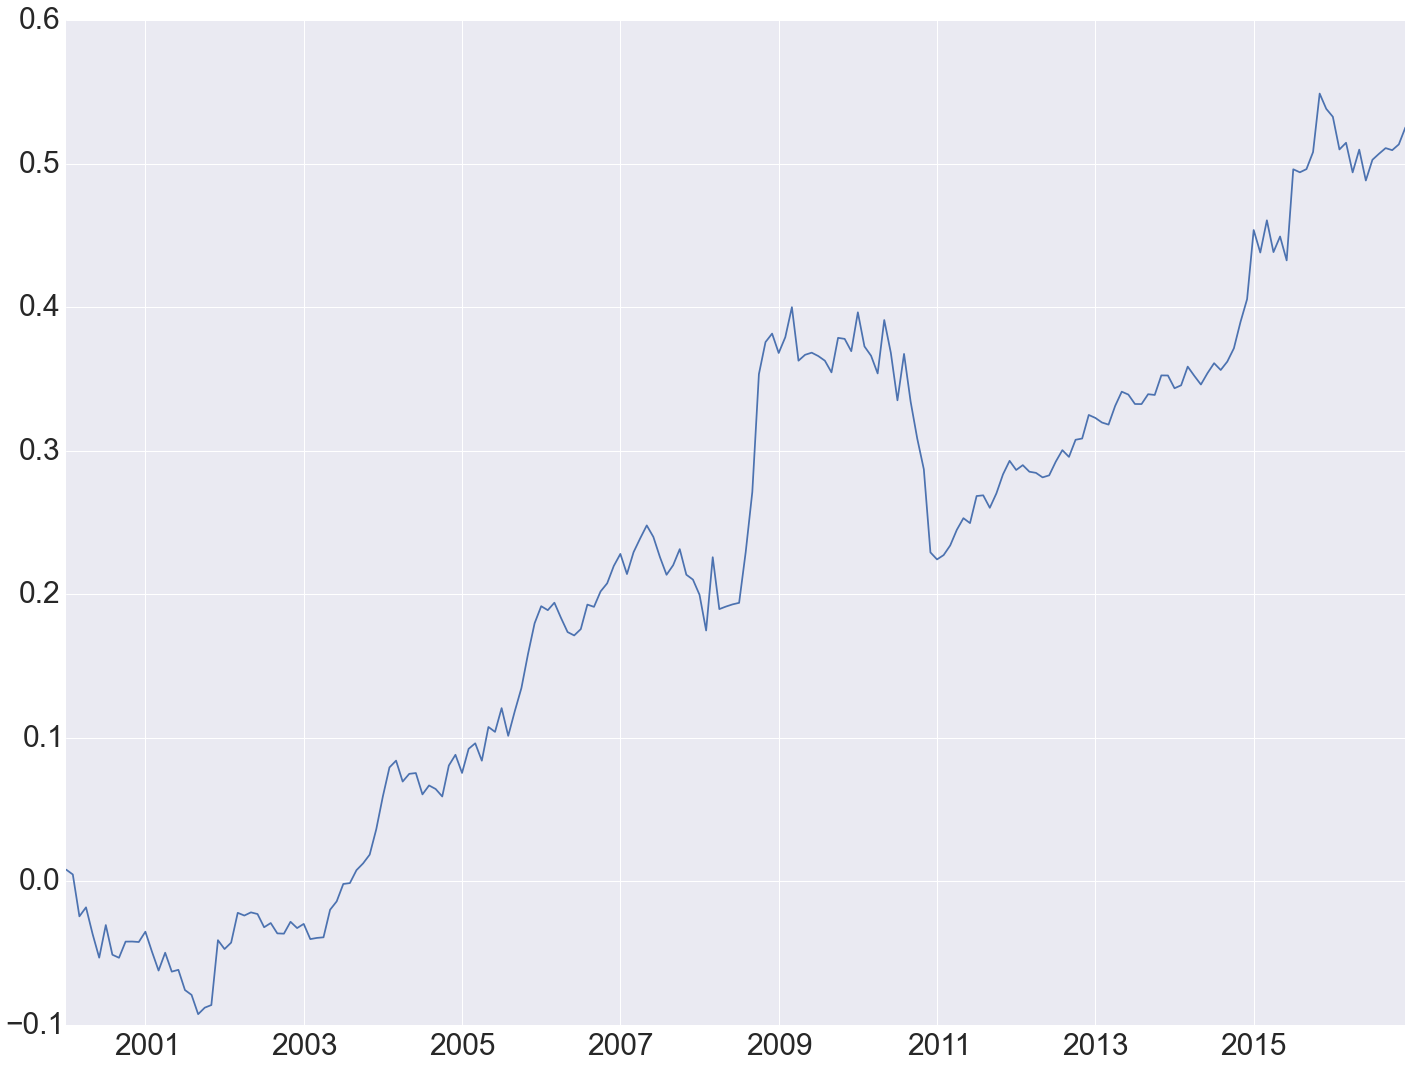

In [138]:
(a['2']-a['0']).cumsum().plot()

In [139]:
calc_Sharpe(a['2']-a['0'])

0.52410134195402891

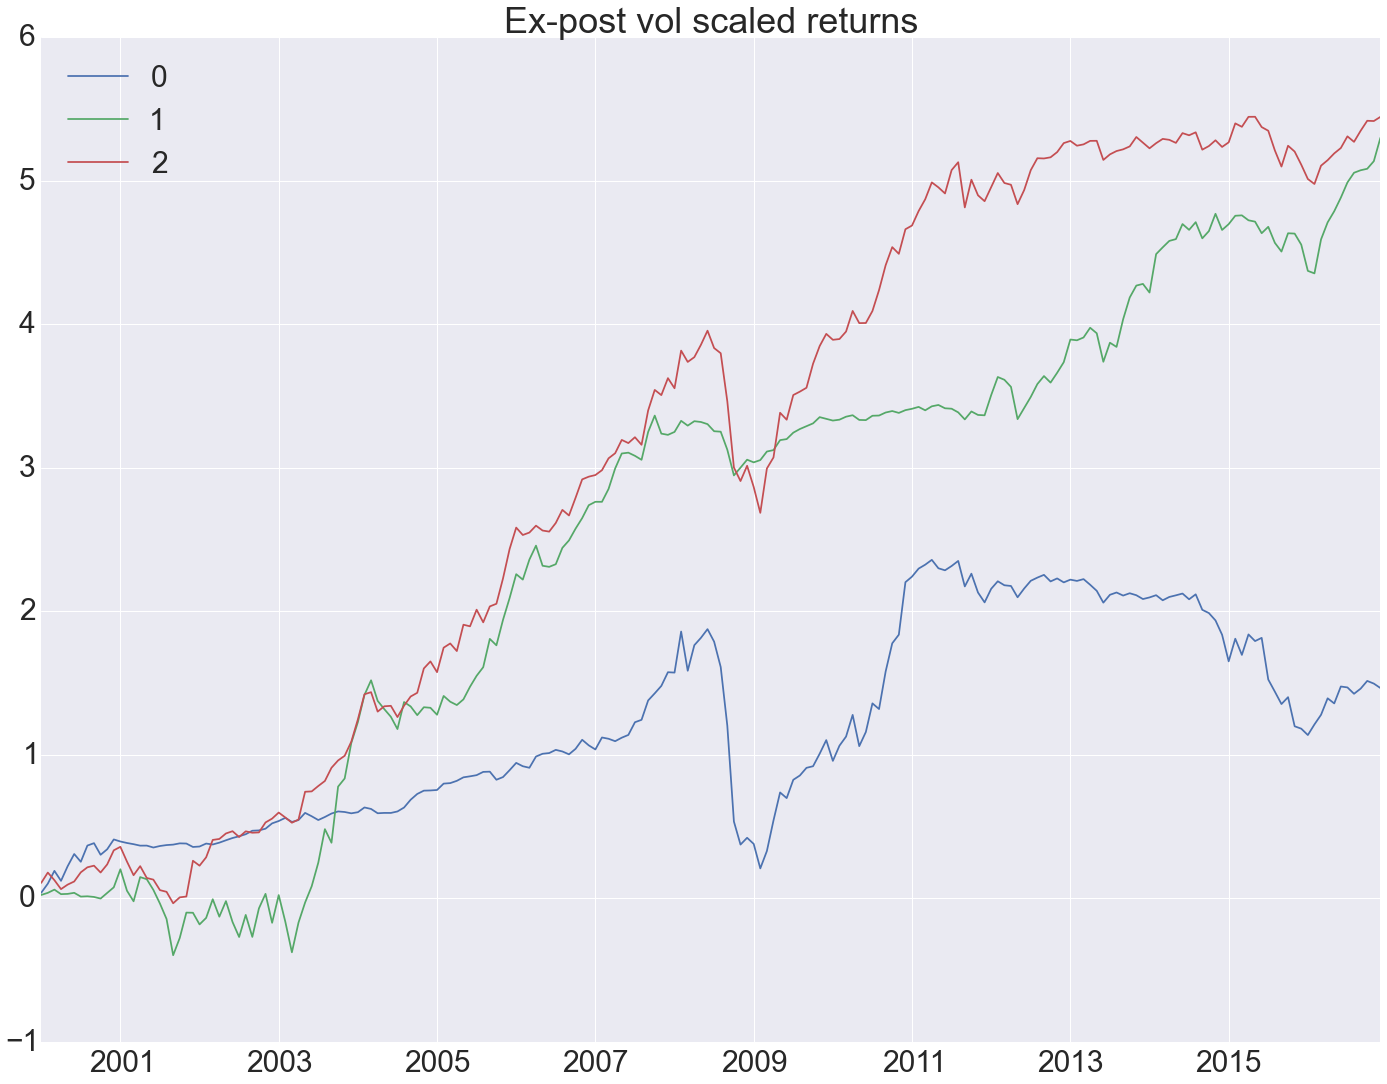

In [115]:
#final=((a*.1)/a.std())
final.cumsum().plot(title='Ex-post vol scaled returns')

Some interesting findings
* The one seemingly right feature about this is that you get slaughtered during the financial crisis
* Very little returns after the crisis given the amount of QE pumped into the markets to give the illusion that everything is liquid
* Now that QE is ending we are starting to see the returns

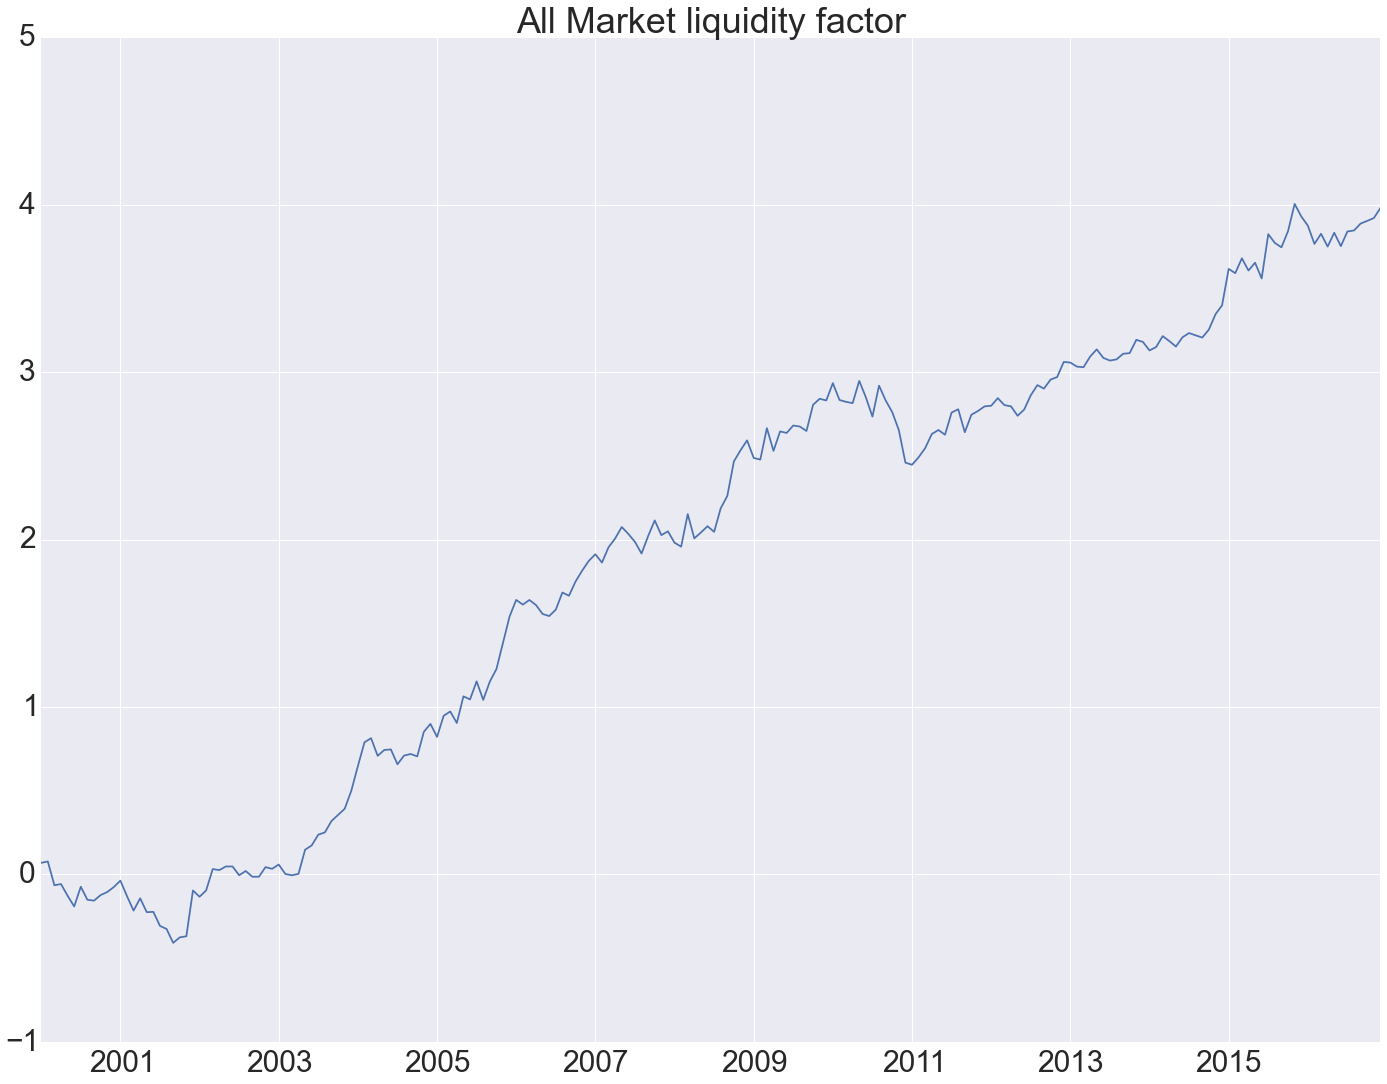

In [116]:
(final['2']-final['0']).cumsum().plot(title='All Market liquidity factor')

In [117]:
calc_Sharpe((final['2']-final['0']))

0.84730227265255298

In [118]:
(final['2']-final['0']).std()*346

27.602712390354636

In [120]:
final.std()

0    0.1
1    0.1
2    0.1
dtype: float64

# Try to vol scale returns

In [106]:
def quantile_portfolios_annual_vol_scaled_rtns(rank_data,price_data,number_of_buckets=10):
    rets=price_data.resample(rule='m',how='last').pct_change()
    rets_scaled=(.1*rets)/rets.std()
    deciles={}
    for i in range(0,number_of_buckets,1):
        deciles[str(i)]=pd.Series()
    for y in range(rank_data.index[0].year,rank_data.index[-1].year,1):
        year=str(y) + '-12-31'
        for i in range(0,number_of_buckets,1):
            mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
            rtns = rets_scaled[mkts][str(y+1)].mean(axis=1)
            deciles[str(i)]=deciles[str(i)].append(rtns)
    return pd.DataFrame(deciles)

In [16]:
x=quantile_portfolios_annual_vol_scaled_rtns(values['All'],cleansed,3)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  # Remove the CWD from sys.path while we load stuff.


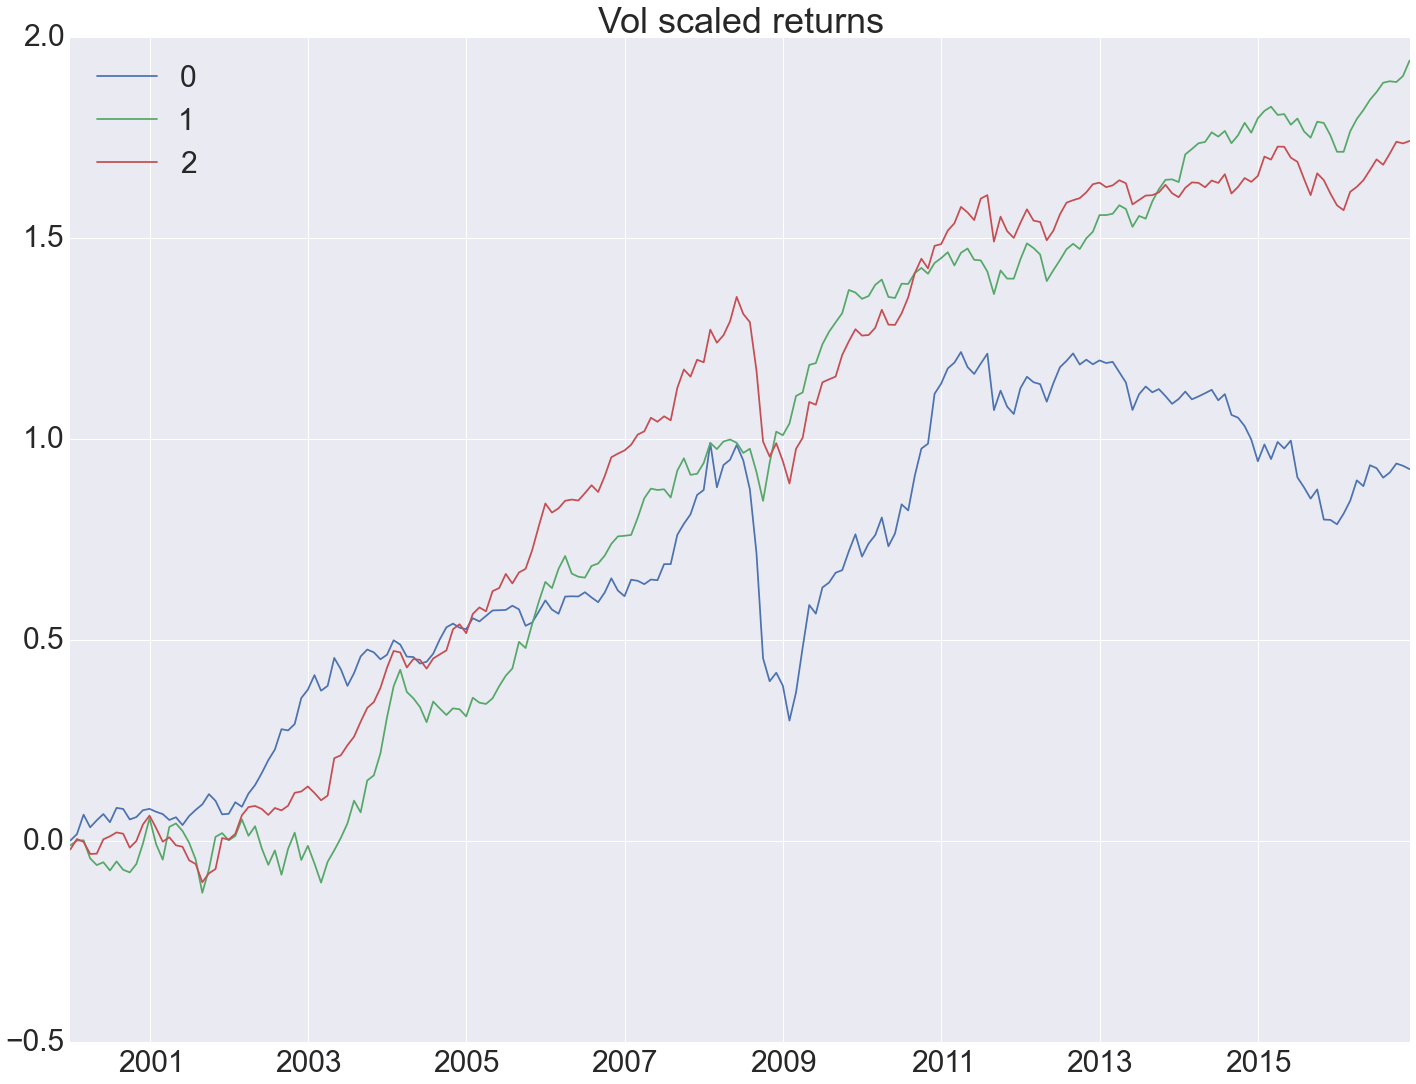

In [17]:
x.dropna().cumsum().plot(title='Vol scaled returns')

In [18]:
x.std()*math.sqrt(12)*100.

0    14.963601
1    12.056311
2    11.948323
dtype: float64

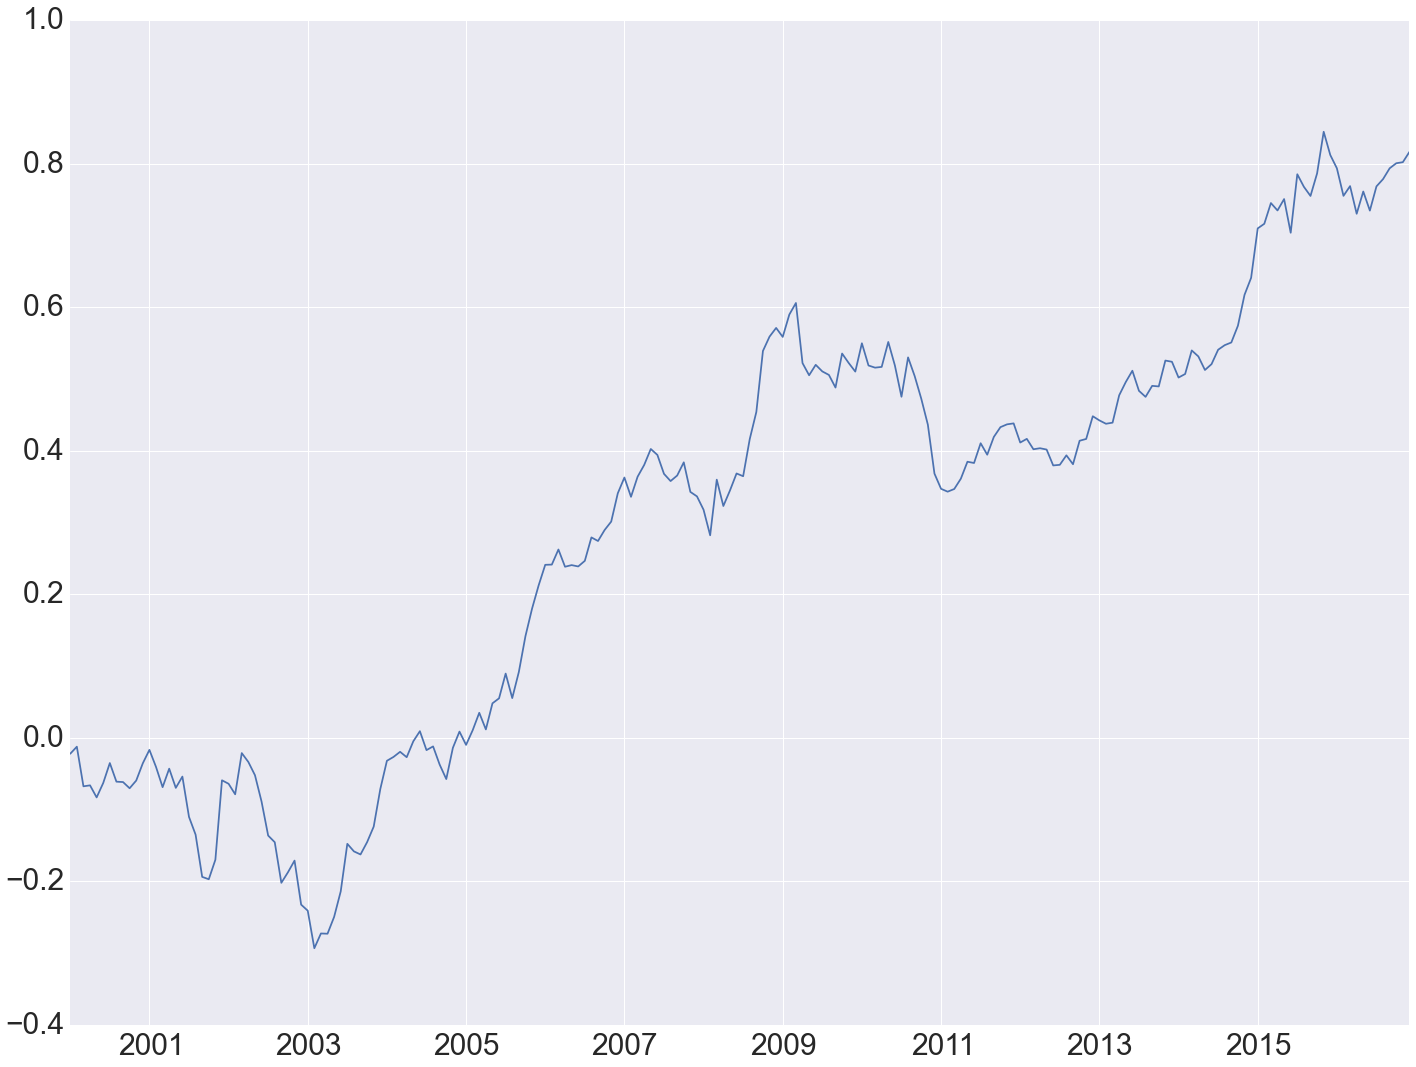

In [19]:
(x['2']-x['0']).cumsum().dropna().plot()

# Rank order

In [21]:
def quantile_portfolios_annual_with_rank_rank_weightings(rank_data,price_data,number_of_buckets=10):
    deciles={}
    med_value={}
    for i in range(0,number_of_buckets,1):
        deciles[str(i)]=pd.Series()
        med_value[str(i)]=pd.Series()
    for y in range(rank_data.index[0].year,rank_data.index[-1].year,1):
        year=str(y) + '-12-31'
        for i in range(0,number_of_buckets,1):
            mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
            q=rank_data[mkts][str(y)].ix[-1].dropna()
            w=q.abs().rank()/q.abs().rank().sum()
            pct_rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)]
            rtns=(pct_rtns*w).sum(axis=1)
            med=rank_data[mkts][str(y+1)].median(axis=1)
            deciles[str(i)]=deciles[str(i)].append(rtns)
            med_value[str(i)]=med_value[str(i)].append(med)
    return pd.DataFrame(deciles),pd.DataFrame(med_value)

In [22]:
j,k=quantile_portfolios_annual_with_rank_rank_weightings(values['All'],cleansed,3)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  # Remove the CWD from sys.path while we load stuff.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  del sys.path[0]


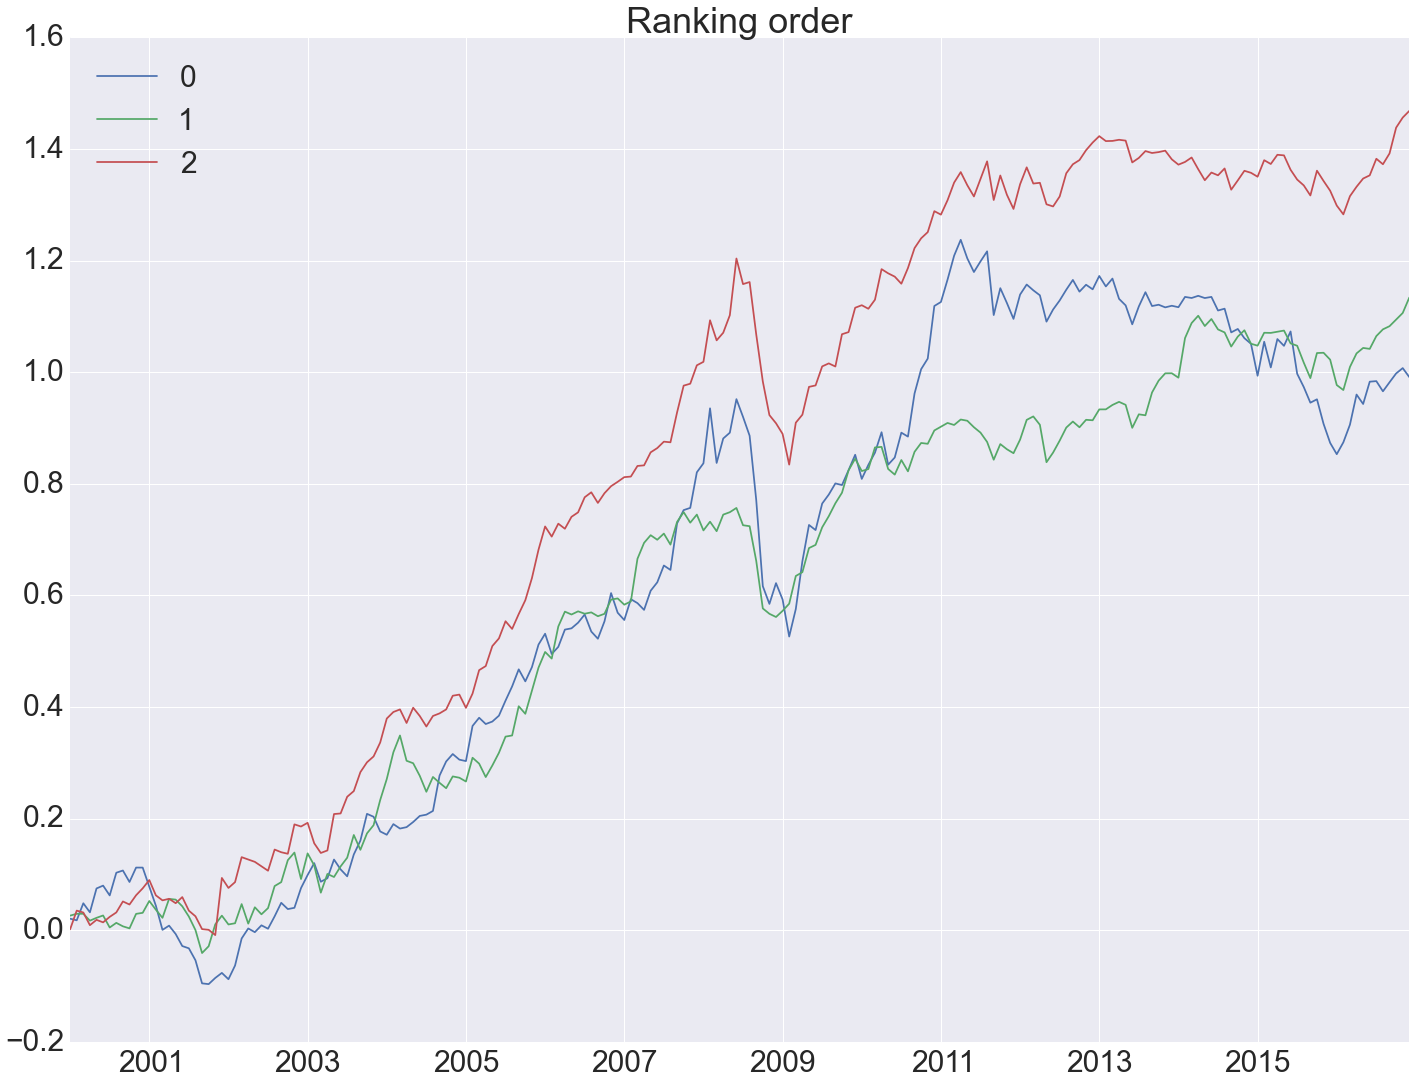

In [23]:
j.cumsum().plot(title='Ranking order')

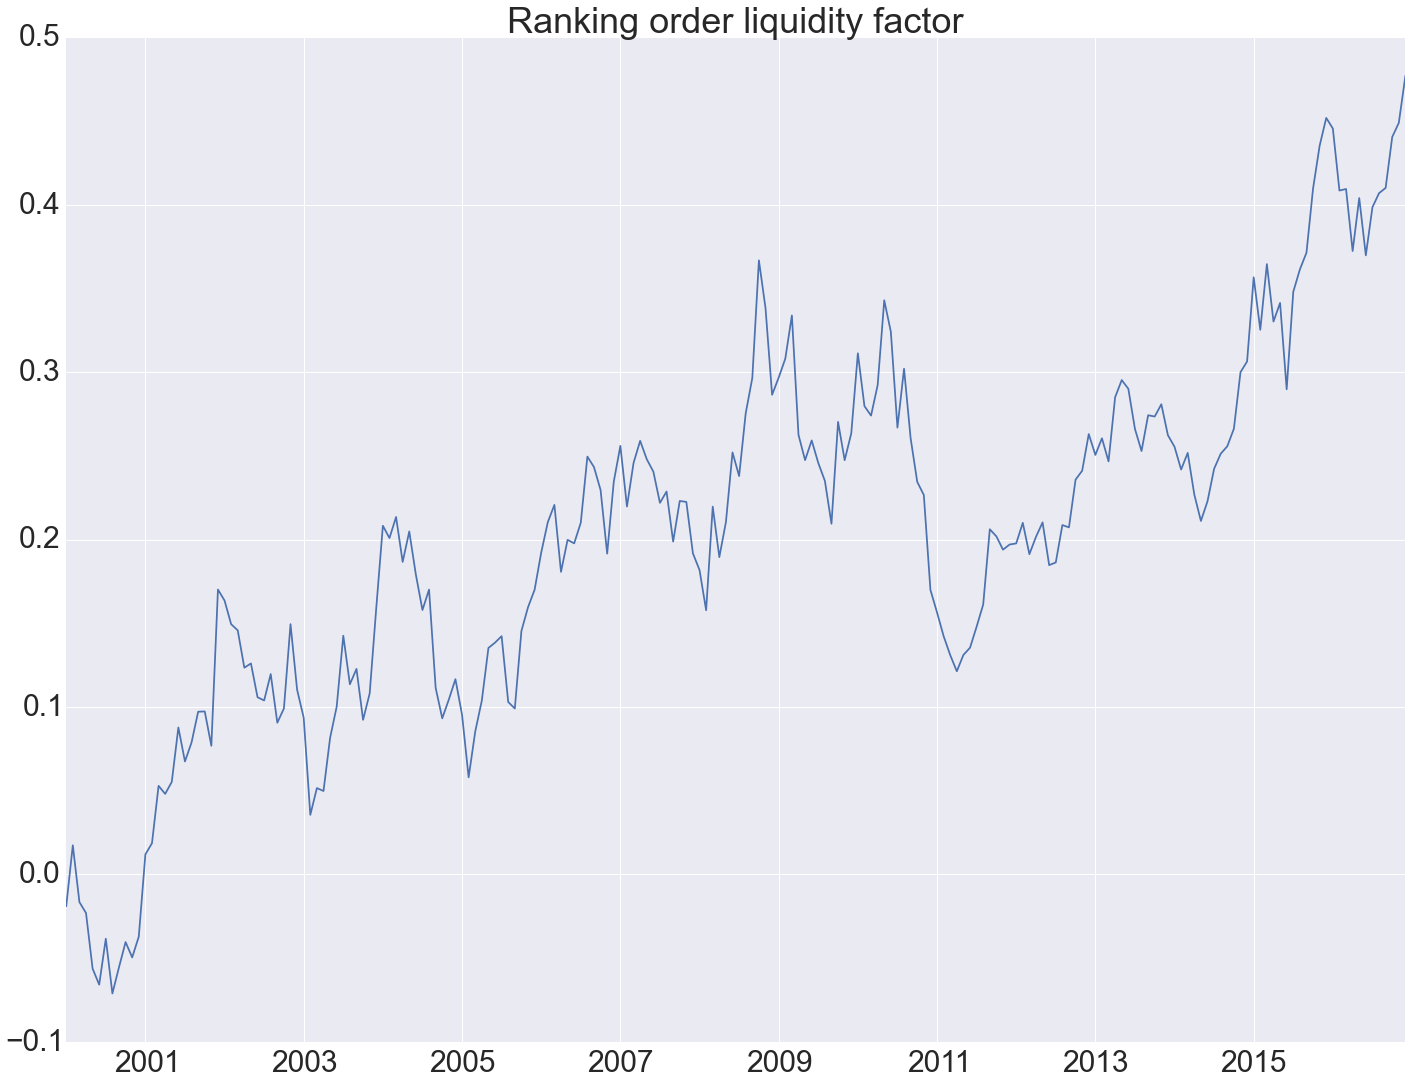

In [24]:
(j['2']-j['0']).cumsum().plot(title='Ranking order liquidity factor ')

In [26]:
original_factors=get_all_factors(3,True)

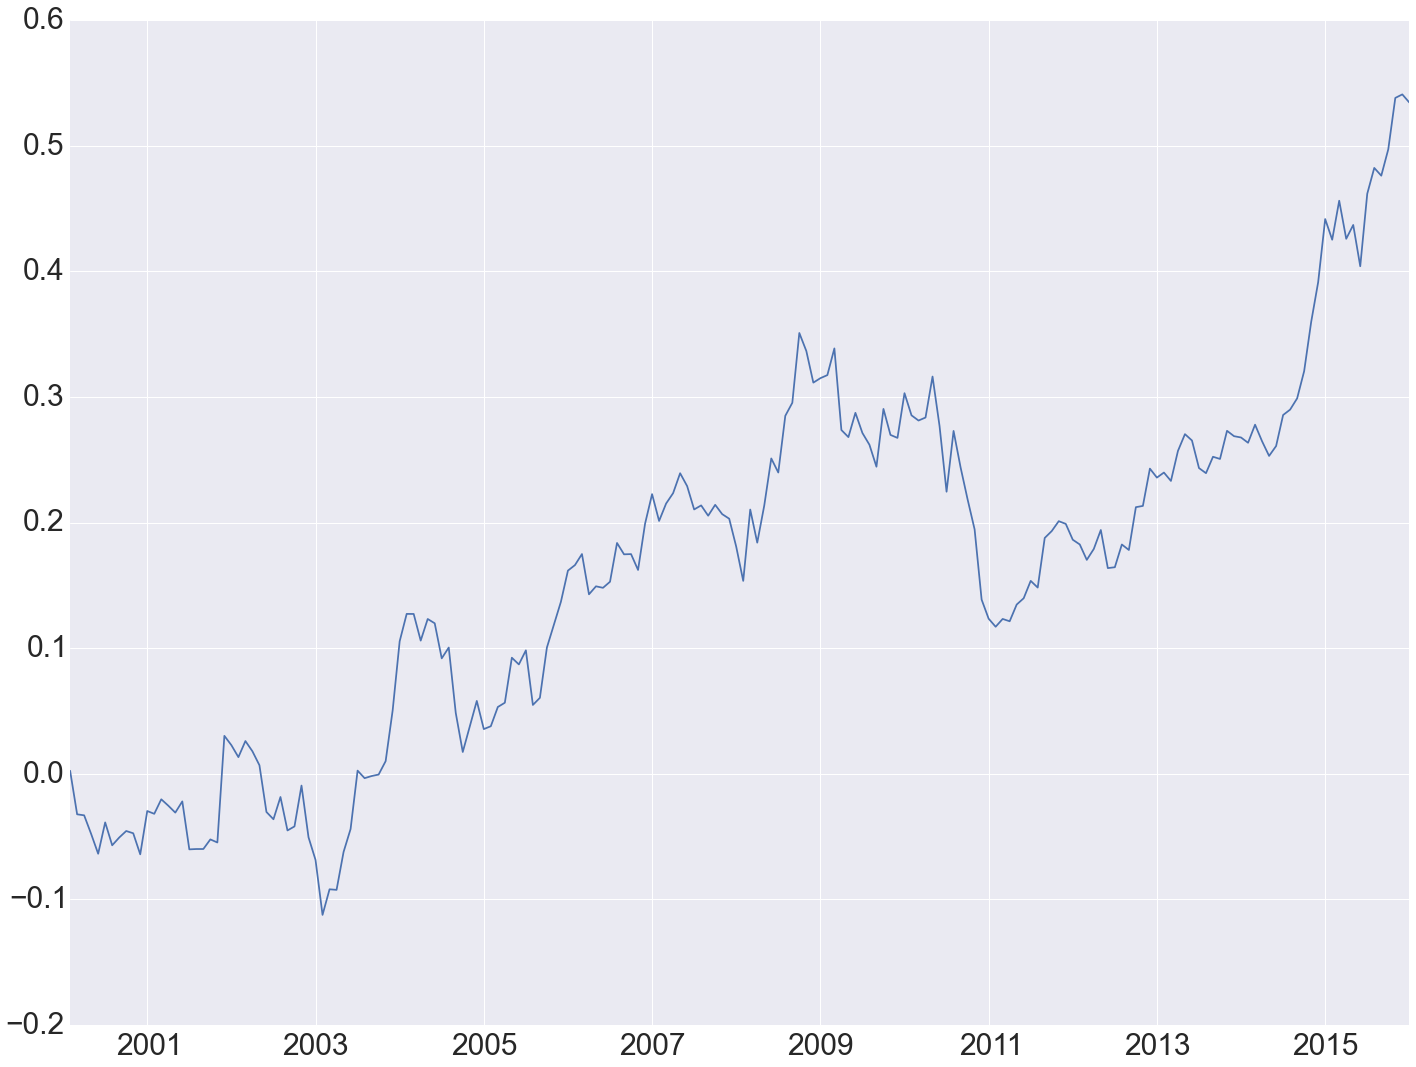

In [27]:
original_factors['Amihud Annual'].cumsum().plot()